# Homework 4

## Joining Data

In this task, I will combine datasets to analyze cell phones per capita across countries. Using the cleaned cell phone data, I’ll integrate population data from pop_data.csv, handling missing values appropriately. Both datasets will be reshaped by pivoting, and I’ll replace iso-3 codes with country names using country_data.csv.

After merging, I’ll calculate cell phones per capita by dividing phone counts by population size and present a table highlighting countries with the highest values in 2019. Finally, I’ll analyze and plot the growth rate of cell phones per capita over the last decade, identifying the fastest-growing country while documenting each step.

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import re
import requests

In [73]:
cell_phones = pd.read_csv("cleaned_cell_phones_total.csv")

In [74]:
population = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv")
population = population.drop(index=[110])
# Fill leading NaN values with the first non-NaN value, and then interpolate
population.loc[196] = population.loc[196].fillna(method='bfill').interpolate(method='linear')

In [83]:
# Drop the 'Unnamed: 0' column if it exists
population = population.loc[:, ~population.columns.str.contains('^Unnamed')]

# Reshape population data to long format
population_long = population.melt(id_vars=["iso-3"], var_name="year", value_name="population")

# Convert 'year' column to integers, dropping invalid rows
population_long["year"] = pd.to_numeric(population_long["year"], errors="coerce")
population_long = population_long.dropna(subset=["year"]).astype({"year": int})

cell_phones_long = cell_phones.melt(id_vars=["iso-3"], var_name="year", value_name="n_cellphones")
cell_phones_long["year"] = cell_phones_long["year"].astype(int)  # Ensure the 'year' column is intege

# Merge cell phone and population data
merged_data = pd.merge(cell_phones_long, population_long, on=["iso-3", "year"], how="inner")
print(merged_data)

      iso-3  year  n_cellphones  population
0       ABW  1960           0.0     54608.0
1       AFG  1960           0.0   8622466.0
2       AGO  1960           0.0   5357195.0
3       ALB  1960           0.0   1608800.0
4       AND  1960           0.0      9443.0
...     ...   ...           ...         ...
11979   XKX  2019           0.0   1788878.0
11980   YEM  2019           0.0  31546691.0
11981   ZAF  2019    97000000.0  58087055.0
11982   ZMB  2019    17200000.0  18380477.0
11983   ZWE  2019    13200000.0  15354608.0

[11984 rows x 4 columns]


In [173]:
# Calculate phones per capita
merged_data["phones_per_capita"] = merged_data["n_cellphones"] / merged_data["population"]


# Load data
country_data = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv")

# Select only relevant columns from country_data
country_data = country_data[["alpha-3", "name"]]

# Rename name_y to name if it exists
if "name_y" in merged_data.columns:
    merged_data = merged_data.rename(columns={"name_y": "name"})

# Drop name_x if it exists
if "name_x" in merged_data.columns:
    merged_data = merged_data.drop(columns=["name_x"])

# Calculate phones per capita
merged_data["phones_per_capita"] = merged_data["n_cellphones"] / merged_data["population"]

# Filter out rows with unrealistic phones_per_capita values
merged_data = merged_data[merged_data["phones_per_capita"] < 10]  # Adjust threshold as needed

# Sort by year and country name
sorted_data = merged_data.sort_values(by=["year", "name"])


# Filter for 2019 and sort by phones_per_capita
top_countries_2019 = merged_data[merged_data["year"] == 2019].sort_values(by="phones_per_capita", ascending=False).head(5)

# Get the names of the top countries
top_country_names = top_countries_2019["name"].tolist()
print("Top countries in 2019:", top_country_names)

# Filter data for top countries from 2015 to 2019
filtered_data = merged_data[
    (merged_data["name"].isin(top_country_names)) & (merged_data["year"] >= 2015)
]

# Create a pivot table
pivot_table = filtered_data.pivot(index="year", columns="name", values="phones_per_capita")

# Sort columns to match the order of top countries
pivot_table = pivot_table[top_country_names]

# Display the pivot table
print(pivot_table)

Top countries in 2019: ['Congo', 'Mauritius', 'Equatorial Guinea', 'Gambia', 'Hong Kong']
name     Congo  Mauritius  Equatorial Guinea    Gambia  Hong Kong
year                                                             
2015  1.030727   1.393641           0.395702  1.207208   2.290401
2016  1.044955   1.432249           0.411744  1.225614   2.398931
2017  0.952499   1.454675           0.390158  1.247280   2.488773
2018  0.918938   1.517095           0.393452  1.300658   2.670209
2019  9.280646   5.375261           4.343120  2.887739   2.863650


The country with the highest growth rate from 2015 to 2019 is Equatorial Guinea with a growth rate of 997.57%.


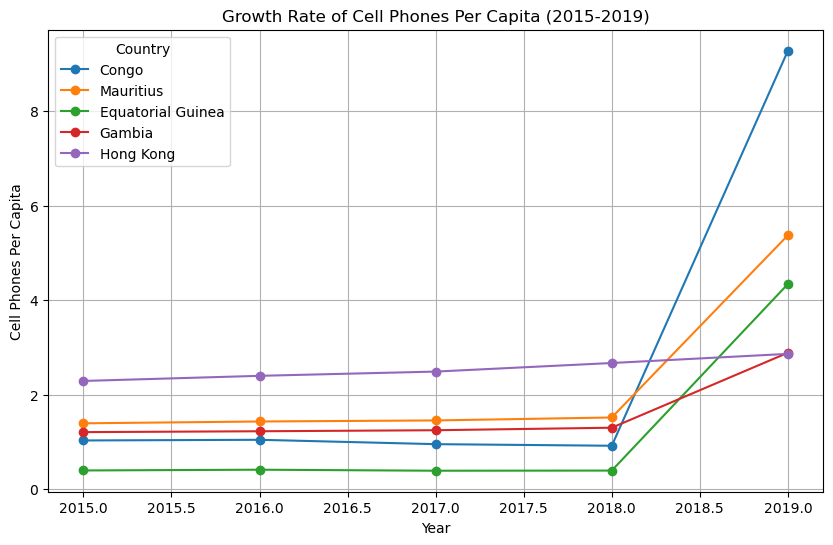

In [176]:
import matplotlib.pyplot as plt

# Calculate the growth rate for each country
growth_rate = (pivot_table.loc[2019] - pivot_table.loc[2015]) / pivot_table.loc[2015] * 100

# Find the country with the highest growth rate
highest_growth_country = growth_rate.idxmax()
highest_growth_rate = growth_rate.max()

print(f"The country with the highest growth rate from 2015 to 2019 is {highest_growth_country} with a growth rate of {highest_growth_rate:.2f}%.")

# Plot the growth trends for all countries
pivot_table.plot(kind='line', marker='o', figsize=(10, 6))

# Highlight the country with the highest growth rate
plt.title("Growth Rate of Cell Phones Per Capita (2015-2019)")
plt.xlabel("Year")
plt.ylabel("Cell Phones Per Capita")
plt.legend(title="Country")
plt.grid(True)
plt.show()

# Task 2

## SQL

In this task I will analyze the user_actions.db SQLite database to solve three tasks using SQL queries. First, I will retrieve the usernames of all users who performed the "signup" action by filtering the user_actions table where the action column equals "signup." Next, I will calculate the total number of log entries for each user by grouping the data by user_id and username and counting their respective entries. Finally, I will identify users who both logged in and signed up on the same day by performing a self-join on the user_actions table, matching user_id and date while filtering for rows where one action is "login" and the other is "signup."

In [147]:
# Path to the SQLite database file
db_path = "user_actions (2).db"  # Update with the exact file name

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Task 1: Retrieve usernames of all users who have performed the "signup" action
task_1_query = """
SELECT DISTINCT username
FROM user_actions
WHERE action = 'signup';
"""
task_1_result = pd.read_sql_query(task_1_query, conn)
print("Task 1: Usernames who performed 'signup':")
print(task_1_result)

Task 1: Usernames who performed 'signup':
   username
0    user34
1    user28
2     user1
3    user24
4    user15
5    user20
6    user18
7    user25
8     user3
9     user9
10   user27
11   user16
12   user17
13    user4
14    user8
15   user13
16   user19
17   user31
18   user10
19   user23
20   user11
21   user33
22   user12
23   user29
24   user21
25    user6
26   user14
27   user30
28    user7
29   user26
30   user22
31    user5
32   user35
33    user2
34   user32


In [148]:
# Task 2: Find the total number of log entries for each user
task_2_query = """
SELECT user_id, username, COUNT(*) AS log_entries_count
FROM user_actions
GROUP BY user_id, username;
"""
task_2_result = pd.read_sql_query(task_2_query, conn)
print("\nTask 2: Total log entries per user:")
print(task_2_result)


Task 2: Total log entries per user:
    user_id username  log_entries_count
0         1    user1                104
1         2    user2                149
2         3    user3                108
3         4    user4                436
4         5    user5                192
5         6    user6                457
6         7    user7                362
7         8    user8                329
8         9    user9                118
9        10   user10                170
10       11   user11                328
11       12   user12                209
12       13   user13                470
13       14   user14                320
14       15   user15                 35
15       16   user16                379
16       17   user17                367
17       18   user18                122
18       19   user19                 58
19       20   user20                362
20       21   user21                323
21       22   user22                275
22       23   user23                309
23 

In [169]:
import sqlite3
import pandas as pd

# Path to the SQLite database file
db_path = "user_actions (2).db"  # Update with your file name

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Query to find users who logged in and signed up on the same day
query = """
SELECT DISTINCT a.user_id, a.username
FROM user_actions a
JOIN user_actions b
  ON a.user_id = b.user_id
  AND DATE(a.timestamp) = DATE(b.timestamp)  -- Ensure both actions occurred on the same date
WHERE a.action = 'login' AND b.action = 'signup';
"""

# Execute the query and load the results into a DataFrame
result = pd.read_sql_query(query, conn)

# Display the results
print("Users who logged in and signed up on the same day:")
print(result)

# Close the connection
conn.close()


Users who logged in and signed up on the same day:
   user_id username
0        8    user8
1       12   user12
2       30   user30
3        7    user7
4       22   user22
5        5    user5
6        2    user2
7       32   user32


# Task 3 

## Regex

In this task I will analyze the comments.txt file to extract and work with hashtags included in user comments. First, I will write a regular expression to extract all hashtags from a given comment, such as #programming and #tips in the comment "Great post! #programming #tips". Next, I will create a regex to identify comments that mention both #programming and #python simultaneously, and I will test it on a specific comment to check if it matches. Finally, I will use the regex to extract all unique hashtags across the entire file, identifying patterns and trends in tag usage. This will allow me to explore how hashtags are used in the comments effectively.

In [139]:
# Fetch comments from the URL
url = "https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/comments.txt"
response = requests.get(url)
comments = response.text.splitlines()  # Split into a list of lines

# Extract the first comment
first_comment = comments[0]  # Assuming the first line is the first comment

# Regex to extract hashtags
regex = r"#\w+"

# Extract hashtags from the first comment
hashtags = re.findall(regex, first_comment)

# Print the first comment and extracted hashtags
print("First Comment:", first_comment)
print("Extracted Hashtags:", hashtags)

First Comment: 1. "Great post! #programming #tips"
Extracted Hashtags: ['#programming', '#tips']


In [141]:
# Extract the second comment (assuming comments are zero-indexed)
comment_2 = comments[1]  # Comment 2 is the second element (index 1)

# Regex to check for both #programming and #python
regex = r"(?=.*#programming)(?=.*#python)"

# Check if the second comment matches
if re.search(regex, comment_2):
    print("Comment 2 mentions both #programming and #python:")
    print(comment_2)
else:
    print("Comment 2 does not mention both #programming and #python.")


Comment 2 does not mention both #programming and #python.


In [142]:
# Find all comments that mention both hashtags
matching_comments = [comment.strip() for comment in comments if re.search(regex, comment)]

# Print all matching comments
print("\nComments mentioning both #programming and #python:")
for comment in matching_comments:
    print(comment)



Comments mentioning both #programming and #python:
6. "I learned a lot. #programming #python #tips"
15. "Well explained. #programming #python #tips"
21. "Love the content! #programming #python #tips"
30. "Inspired by the tips. #programming #python #tips"
